## Code walkthrough

In [432]:
import importlib
import os
import time
import base64
from dotenv import load_dotenv
import cv2
from openai import AsyncOpenAI
from video_labeling.utils import extract_frames_from_video
from IPython.display import Image

In [1895]:
import video_labeling
importlib.reload(video_labeling)

<module 'video_labeling' from '/Users/niccolofusai/Documents/pi/video_labeling/__init__.py'>

In [434]:
from video_labeling.main import identify_moved_objects, label_actions_in_episode, label_episode_frame_ranges, check_episode_frame_number_labels, adjusting_frames_in_episode

In [435]:
def render_video(start_frame, end_frame, fps, render_frame=-1): 
    frames = extract_frames_from_video(VIDEO_PATH, start_frame, end_frame, fps=fps)
    
    display_handle = display(None, display_id=True)
    for idx, img in enumerate(frames):  
        if idx==render_frame: 
            display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
            time.sleep(0.1)
            break
        else:    
            display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
            time.sleep(0.1)

#### Load in your env variables

In [436]:
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
VIDEO_PATH = os.getenv('VIDEO_PATH')
FRAMES_SEGMENT_SIZE = int(os.getenv('FRAMES_SEGMENT_SIZE'))

print(VIDEO_PATH)
print(FRAMES_SEGMENT_SIZE)

/Users/niccolofusai/Documents/pi/data/input/pi_video_test.mp4
300


In [437]:
client = AsyncOpenAI(api_key=OPENAI_API_KEY)

## Step 0: Get frame ranges

In [438]:
video = cv2.VideoCapture(VIDEO_PATH)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video.release()
video_chunks = [
    (max(0, i - FRAMES_SEGMENT_SIZE), min(total_frames, i))
    for i in range(
        FRAMES_SEGMENT_SIZE, total_frames + FRAMES_SEGMENT_SIZE, FRAMES_SEGMENT_SIZE
    )
]

In [439]:
print(f"total frames are: {total_frames}")
print(f"video chunks are: {video_chunks}")

total frames are: 1116
video chunks are: [(0, 300), (300, 600), (600, 900), (900, 1116)]


## Step 1: Identify which objects have moved in the chunks

In [440]:
moved_objects = await identify_moved_objects(client, VIDEO_PATH, video_chunks)

In [441]:
moved_objects

[{'moved_objects': ['Glass Bowl', 'Cardboard Food Container']},
 {'moved_objects': ['Plastic Bowl', 'Orange Plate']},
 {'moved_objects': ['Metal Spoon', 'Aluminum Container']},
 {'moved_objects': ['Black Chopstick']}]

Great now we see which object has moved for each video chunk above.  
The next step is to determine the action that took place in each chunk

## Step 2: Identify the actions that took place in those chunks

In [442]:
labeled_actions = await label_actions_in_episode(client, VIDEO_PATH, moved_objects, video_chunks)


Pick up Black Chopstick


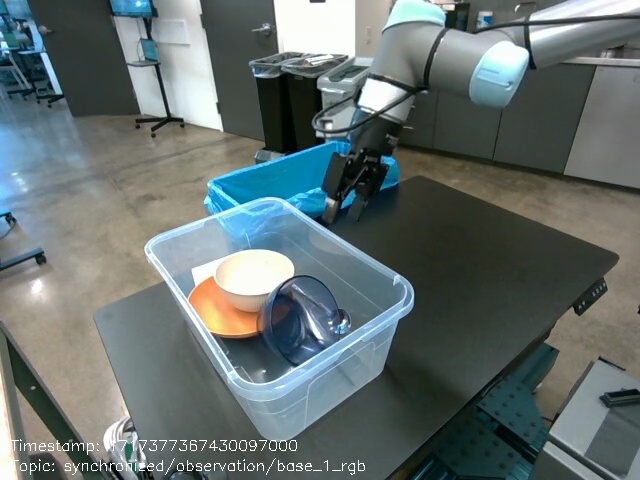

In [460]:
idx = 12
labeled_actions[idx]
test = labeled_actions[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10)

Great here we see the actions labeled correctly. We fed in the objects that had moved to the model and it determined correctly which actions had taken place.  
You also see the model outputted the image range. This is a second order priority for the model, and while they are "roughly" accurate, a lot of work needs to be done in identifying the correct ranges.

## Step 3: Identify correct start and end frame for the action in the episode

In [1728]:
LABEL_PICKUP_ACTION = """
### Analyze the Robot's Pickup Action

**Action Description:**
The robot attempts to pick up the object `{object}`. Your task is to identify the precise images where the pickup action starts and ends.

**Objective:**
Meticulously determine the exact image numbers marking the start and conclusion of the pickup action involving `{object}`.

**Instructions:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot gripper should not be grasping or holding any objects, including `{object}`
   - **Criterion 2:** There should be plenty of space between the gripper and {object}, and the following frames should capture the robot gripper moving towards the `{object}`, before it picks it up. 
   - **Criterion 3:** The first object that is picked up in the consecutive images after the start image must be {object}

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** The image where the `{object}` has just been picked up by the gripper, with a significant visible gap between the table and the {object}. If `{object}` is still touching the table, the image is too early.
   - **Criterion 2:** The `{object}` must not yet have started moving towards the destination (bin / container). If it is over the bin / container, the image is too late.
   - **Criterion 3:** The `{object}` must not have been released from the gripper. If it has, the image is way too late. 
   
**Focus Points:**
   - Concentrate solely on interactions involving `{object}`.
   - Ignore any images where the robot interacts with other objects not relevant to the specific pickup action of `{object}`.

**Expected Deliverables:**
   - Document the image numbers that correctly represent both the start and end of the pickup action.
   - Double-check the images against these criteria to ensure accuracy.

**Sample Response Format:**
```json
{{
  "start_image": [image number],
  "end_image": [image number]
}}
"""


LABEL_DEPOSIT_ACTION = """
### Analyze the Robot's Depositing Action

**Action Description:**
The robot is engaged in depositing the object `{object}` into its designated destination. Your task is to identify the precise images where the depositing action begins and ends.

**Objective:**
Accurately determine the exact image numbers marking the start and conclusion of the depositing action involving `{object}`.

**Instructions:**

**1. Start Image Criteria for Deposit:**
   - **Criterion 1:** Identify the image where the robot’s gripper has lifted the `{object}` above the table. There should be a signifcant visible gap between the table and the {object}.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Deposit:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Focus Points:**
   - Maintain an exclusive focus on interactions involving `{object}`.
   - Ignore images involving other objects unless they directly impact the depositing action.

**Expected Deliverables:**
   - Document the image numbers for both the start and end of the deposit action.
   - Ensure the images meet the detailed criteria listed above for accurate assessment.

**Sample Response Format:**
```json
{{
  "start_image": [image number],
  "end_image": [image number]
}}
"""

In [1818]:
LABEL_PICKUP_ACTION = """
### Analyze the Robot's Pickup Action

**Action Description:**
The robot attempts to pick up the object `{object}`. Your task is to identify the precise images where the pickup action starts and ends.

**Objective:**
Meticulously determine the exact image numbers marking the start and conclusion of the pickup action involving `{object}`.

**Instructions:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The first image should be the first image the robot gripper begins moving towards the {object}. This means there should be plenty of space between the gripper and {object}
   - **Criterion 2:** The robot gripper should not be grasping or holding any objects, including `{object}`
   - **Criterion 3:** The gripper should be distant from any object. There should be at several images before the gripper makes contact with {object}. if the gripper is already close to the object, the image is too late.

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** The image where the `{object}` has just been picked up by the gripper, with a significant visible gap between the table and the {object}. If `{object}` is still touching the table, the image is too early.
   - **Criterion 2:** The `{object}` must not yet have started moving towards the destination (bin / container). If it is over the bin / container, the image is too late.
   - **Criterion 3:** The `{object}` must not have been released from the gripper. If it has, the image is way too late. 
   
**Focus Points:**
   - Concentrate solely on interactions involving `{object}`.
   - Ignore any images where the robot interacts with other objects not relevant to the specific pickup action of `{object}`.

**Expected Deliverables:**
   - Document the image numbers that correctly represent both the start and end of the pickup action.
   - Double-check the images against these criteria to ensure accuracy.

**Sample Response Format:**
```json
{{
  "start_image": [image number],
  "end_image": [image number]
}}
"""


LABEL_DEPOSIT_ACTION = """
### Analyze the Robot's Depositing Action

**Action Description:**
The robot is engaged in depositing the object `{object}` into its designated destination. Your task is to identify the precise images where the depositing action begins and ends.

**Objective:**
Accurately determine the exact image numbers marking the start and conclusion of the depositing action involving `{object}`.

**Instructions:**

**1. Start Image Criteria for Deposit:**
   - **Criterion 1:** Identify the image where the robot’s gripper has lifted the `{object}` above the table. There should be a signifcant visible gap between the table and the {object}.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Deposit:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Focus Points:**
   - Maintain an exclusive focus on interactions involving `{object}`.
   - Ignore images involving other objects unless they directly impact the depositing action.

**Expected Deliverables:**
   - Document the image numbers for both the start and end of the deposit action.
   - Ensure the images meet the detailed criteria listed above for accurate assessment.

**Sample Response Format:**
```json
{{
  "start_image": [image number],
  "end_image": [image number]
}}
"""

In [1819]:
import asyncio
import copy

from config import FPS_OPTIONS
from video_labeling.utils import extract_frames_from_video
from video_labeling.prompts.shared import SYSTEM_PROMPT

from video_labeling.utils import (
    adjust_task_frames,
    vlm_request,
    calculate_expanded_range,
)


async def label_episode_frame_ranges(client, video_path, labeled_actions, fps=5):
    tasks_to_process = []
    for action in labeled_actions:
        tasks_to_process.append(
            label_action_frame_range(client, video_path, copy.deepcopy(action), fps)
        )

    responses = await asyncio.gather(*tasks_to_process)
    filtered_responses = [response for response in responses if response is not None]

    return filtered_responses


async def label_action_frame_range(client, video_path, action_dict, fps):
    """Process a single robot task by calculating the range, getting frames, and analyzing the task."""
    video_fps = 30
    buffer_multiplier = 2

    expanded_start, expanded_end = calculate_expanded_range(action_dict['start_frame'], action_dict['end_frame'], buffer_multiplier=buffer_multiplier)
    
    frames = extract_frames_from_video(
        video_path, start_frame=expanded_start, end_frame=expanded_end, fps=fps
    )

    # We want to make sure images are between the desired amount of 8 - 18
    while not (8 <= len(frames) <= 18):
        if len(frames) < 8:
            # Increase fps to the next higher option if below the minimum frame count
            current_index = FPS_OPTIONS.index(fps)
            if current_index < len(FPS_OPTIONS) - 1:
                fps = FPS_OPTIONS[current_index + 1]
            else:
                # If already at max fps and frames are still not enough, exit the loop
                break
        elif len(frames) > 18:
            # Decrease fps to the next lower option if above the maximum frame count
            current_index = FPS_OPTIONS.index(fps)
            if current_index > 0:
                fps = FPS_OPTIONS[current_index - 1]
            else:
                # If already at minimum fps and frames are still too many, exit the loop
                break

        frames = extract_frames_from_video(
            video_path,
            start_frame=expanded_start,
            end_frame=expanded_end,
            fps=fps,
        )


    if action_dict["action_type"] == "pick":
        timestep_prompt = LABEL_PICKUP_ACTION.format(
            action=action_dict["action"], object=action_dict["object"]
        )
    else:
        timestep_prompt = LABEL_DEPOSIT_ACTION.format(
            action=action_dict["action"], object=action_dict["object"]
        )

    response = await vlm_request(
        client, SYSTEM_PROMPT, timestep_prompt, frames, temperature=0, extract_json=True
    )

    if response is None:
            return None

    start_image_number = int(response.get("start_image", None)) or None
    end_image_number = int(response.get("end_image", None)) or None

    if not start_image_number or not end_image_number: 
        return None
    

    start_frame = expanded_start + (start_image_number - 1) * video_fps / fps
    if action_dict["action_type"] == "pick":
        start_frame -= 15
    end_frame = expanded_start + (end_image_number) * video_fps / fps

    result = {
        "action": action_dict["action"],
        "start_image": start_image_number,
        "end_image": end_image_number,
        "start_frame": start_frame,
        "end_frame": end_frame,
        "fps": fps,
        "action_type": action_dict["action_type"],
        "object": action_dict["object"],
    }

    return result

In [1820]:
test_frame_labels = await label_episode_frame_ranges(client, VIDEO_PATH, labeled_actions)


In [1821]:
test_frame_labels[0]

{'action': 'Pick up Glass Bowl',
 'start_image': 3,
 'end_image': 8,
 'start_frame': 15.0,
 'end_frame': 120.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Glass Bowl'}

In [1759]:
new_labeled_frames_test[4]

{'action': 'Pick up Orange Plate',
 'start_image': 1,
 'end_image': 7,
 'start_frame': 285.0,
 'end_frame': 370.0,
 'fps': 3,
 'action_type': 'pick',
 'object': 'Orange Plate'}

In [1849]:
idx =12
test_frame_labels[idx]
test = test_frame_labels[idx]

Pick up Black Chopstick


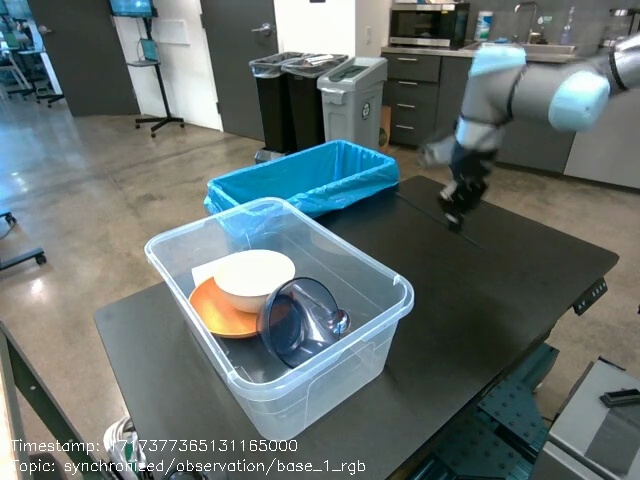

In [1851]:
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10)
# render_video(test['start_frame'], test['end_frame'], 10,0)

So you can see, it did pretty well. Now lets run our checks

### Step 4: Running Checks

In [838]:
new_labeled_frames_test = [{'action': 'Pick up Glass Bowl',
  'start_image': 1,
  'end_image': 10,
  'start_frame': -15.0,
  'end_frame': 100.0,
  'fps': 3,
  'action_type': 'pick',
  'object': 'Glass Bowl'},
 {'action': 'Put Glass Bowl into Clear Plastic Box',
  'start_image': 2,
  'end_image': 9,
  'start_frame': 100.0,
  'end_frame': 180.0,
  'fps': 3,
  'action_type': 'put',
  'object': 'Glass Bowl'},
 {'action': 'Pick up Cardboard Food Container',
  'start_image': 6,
  'end_image': 10,
  'start_frame': 185.0,
  'end_frame': 250.0,
  'fps': 3,
  'action_type': 'pick',
  'object': 'Cardboard Food Container'},
 {'action': 'Put Cardboard Food Container into Blue Trash Bin',
  'start_image': 4,
  'end_image': 7,
  'start_frame': 240.0,
  'end_frame': 280.0,
  'fps': 3,
  'action_type': 'put',
  'object': 'Cardboard Food Container'},
 {'action': 'Pick up Orange Plate',
  'start_image': 1,
  'end_image': 5,
  'start_frame': 285.0,
  'end_frame': 350.0,
  'fps': 3,
  'action_type': 'pick',
  'object': 'Orange Plate'},
 {'action': 'Put Orange Plate into Clear Plastic Box',
  'start_image': 2,
  'end_image': 9,
  'start_frame': 340.0,
  'end_frame': 420.0,
  'fps': 3,
  'action_type': 'put',
  'object': 'Orange Plate'},
 {'action': 'Pick up Plastic Bowl',
  'start_image': 1,
  'end_image': 8,
  'start_frame': 375.0,
  'end_frame': 470.0,
  'fps': 3,
  'action_type': 'pick',
  'object': 'Plastic Bowl'},
 {'action': 'Put Plastic Bowl into Clear Plastic Box',
  'start_image': 4,
  'end_image': 9,
  'start_frame': 450.0,
  'end_frame': 510.0,
  'fps': 3,
  'action_type': 'put',
  'object': 'Plastic Bowl'},
 {'action': 'Pick up Metal Spoon',
  'start_image': 1,
  'end_image': 11,
  'start_frame': 555.0,
  'end_frame': 735.0,
  'fps': 2,
  'action_type': 'pick',
  'object': 'Metal Spoon'},
 {'action': 'Put Metal Spoon into Clear Plastic Box',
  'start_image': 3,
  'end_image': 9,
  'start_frame': 710.0,
  'end_frame': 780.0,
  'fps': 3,
  'action_type': 'put',
  'object': 'Metal Spoon'},
 {'action': 'Pick up Aluminum Container',
  'start_image': 2,
  'end_image': 9,
  'start_frame': 715.0,
  'end_frame': 810.0,
  'fps': 3,
  'action_type': 'pick',
  'object': 'Aluminum Container'},
 {'action': 'Put Aluminum Container into Blue Trash Bin',
  'start_image': 3,
  'end_image': 8,
  'start_frame': 800.0,
  'end_frame': 860.0,
  'fps': 3,
  'action_type': 'put',
  'object': 'Aluminum Container'},
 {'action': 'Pick up Black Chopstick',
  'start_image': 1,
  'end_image': 12,
  'start_frame': 855.0,
  'end_frame': 1050.0,
  'fps': 2,
  'action_type': 'pick',
  'object': 'Black Chopstick'},
 {'action': 'Put Black Chopstick into Clear Plastic Box',
  'start_image': 3,
  'end_image': 12,
  'start_frame': 1032.0,
  'end_frame': 1092.0,
  'fps': 5,
  'action_type': 'put',
  'object': 'Black Chopstick'}]

In [839]:
new_labeled_frames_test

[{'action': 'Pick up Glass Bowl',
  'start_image': 1,
  'end_image': 10,
  'start_frame': -15.0,
  'end_frame': 100.0,
  'fps': 3,
  'action_type': 'pick',
  'object': 'Glass Bowl'},
 {'action': 'Put Glass Bowl into Clear Plastic Box',
  'start_image': 2,
  'end_image': 9,
  'start_frame': 100.0,
  'end_frame': 180.0,
  'fps': 3,
  'action_type': 'put',
  'object': 'Glass Bowl'},
 {'action': 'Pick up Cardboard Food Container',
  'start_image': 6,
  'end_image': 10,
  'start_frame': 185.0,
  'end_frame': 250.0,
  'fps': 3,
  'action_type': 'pick',
  'object': 'Cardboard Food Container'},
 {'action': 'Put Cardboard Food Container into Blue Trash Bin',
  'start_image': 4,
  'end_image': 7,
  'start_frame': 240.0,
  'end_frame': 280.0,
  'fps': 3,
  'action_type': 'put',
  'object': 'Cardboard Food Container'},
 {'action': 'Pick up Orange Plate',
  'start_image': 1,
  'end_image': 5,
  'start_frame': 285.0,
  'end_frame': 350.0,
  'fps': 3,
  'action_type': 'pick',
  'object': 'Orange Plat

Pick up Aluminum Container
715.0 810.0


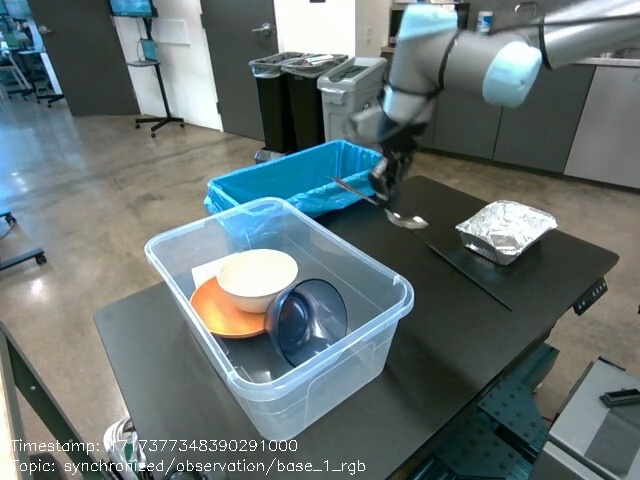

In [840]:
idx = 10
test = new_labeled_frames_test[idx]
print(test['action'])
print(test['start_frame'], test['end_frame'])
render_video(test['start_frame'], test['end_frame'], 10 ,0)

In [1886]:
import json
# Specify the path to your file
file_path = '/Users/niccolofusai/Documents/pi/new_labeled_objects_checkpoint.json'

# Open the file and load the data
with open(file_path, 'r') as file:
    data = json.load(file)

# Now 'data' holds the Python representation of the data in your JSON file
print(data)

[{'action': 'Pick up Glass Bowl', 'start_image': 7, 'end_image': 9, 'start_frame': 75.0, 'end_frame': 135.0, 'fps': 2, 'action_type': 'pick', 'object': 'Glass Bowl'}, {'action': 'Put Glass Bowl into Clear Plastic Box', 'start_image': 4, 'end_image': 8, 'start_frame': 105.0, 'end_frame': 180.0, 'fps': 2, 'action_type': 'put', 'object': 'Glass Bowl'}, {'action': 'Pick up Cardboard Food Container', 'start_image': 9, 'end_image': 13, 'start_frame': 185.0, 'end_frame': 250.0, 'fps': 3, 'action_type': 'pick', 'object': 'Cardboard Food Container'}, {'action': 'Put Cardboard Food Container into Blue Trash Bin', 'start_image': 5, 'end_image': 8, 'start_frame': 210.0, 'end_frame': 270.0, 'fps': 2, 'action_type': 'put', 'object': 'Cardboard Food Container'}, {'action': 'Pick up Orange Plate', 'start_image': 3, 'end_image': 7, 'start_frame': 275.0, 'end_frame': 340.0, 'fps': 3, 'action_type': 'pick', 'object': 'Orange Plate'}, {'action': 'Put Orange Plate into Clear Plastic Box', 'start_image': 4,

Pick up Black Chopstick


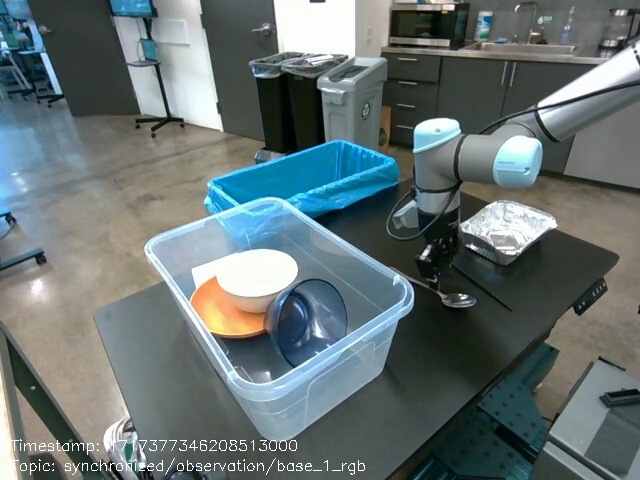

In [1893]:
idx = 12
test = data[idx]
print(test['action'])
# render_video(test['start_frame'], test['end_frame'], 10 ,0)
render_video(675.0, 800, 10 ,0)

In [1158]:
print(f"Step 4: Running checks...")
checks_feedback = await check_episode_frame_number_labels(client, VIDEO_PATH, data, fps=5)


Step 4: Running checks...


In [1160]:
checks_feedback[12]

{'action': 'Pick up Black Chopstick',
 'start_image': 1,
 'end_image': 14,
 'start_frame': 825.0,
 'end_frame': 1050.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Black Chopstick',
 'start_answer': '[Reasoning]\nIn the first three images, the robot arm is positioned above the black table, and it appears to be holding an object. The object in question is long and thin, which matches the description of the black chopstick. There are no other objects in the scene that fit this description. Therefore, it is reasonable to conclude that the robot is holding the black chopstick.\n\n```json\n{\n"answer":"perfect"\n}\n```',
 'end_answer': '[Reasoning]\nIn the final image, the black chopstick is clearly visible and is being grasped by the robot\'s gripper. The chopstick is lifted off the table, as there is visible space between the chopstick and the table. This satisfies the criteria for the END image of the action "Pick up Black Chopstick."\n\n```json \n{\n"answer":"perfect"\n}\n```',
 'sta

In [1885]:
import json
# Specify the path to your file
file_path = '/Users/niccolofusai/Documents/pi/test_new_labeled_objects_checkpoint.json'

# Open the file and load the data
with open(file_path, 'r') as file:
    sec_data = json.load(file)

# Now 'data' holds the Python representation of the data in your JSON file
print(sec_data)

[{'action': 'Pick up Glass Bowl', 'start_image': 3, 'end_image': 9, 'start_frame': 30.0, 'end_frame': 135.0, 'fps': 2, 'action_type': 'pick', 'object': 'Glass Bowl'}, {'action': 'Put Glass Bowl into Clear Plastic Box', 'start_image': 5, 'end_image': 8, 'start_frame': 120.0, 'end_frame': 180.0, 'fps': 2, 'action_type': 'put', 'object': 'Glass Bowl'}, {'action': 'Pick up Cardboard Food Container', 'start_image': 7, 'end_image': 10, 'start_frame': 210.0, 'end_frame': 270.0, 'fps': 2, 'action_type': 'pick', 'object': 'Cardboard Food Container'}, {'action': 'Put Cardboard Food Container into Blue Trash Bin', 'start_image': 7, 'end_image': 10, 'start_frame': 240.0, 'end_frame': 280.0, 'fps': 3, 'action_type': 'put', 'object': 'Cardboard Food Container'}, {'action': 'Pick up Orange Plate', 'start_image': 3, 'end_image': 9, 'start_frame': 290.0, 'end_frame': 360.0, 'fps': 3, 'action_type': 'pick', 'object': 'Orange Plate'}, {'action': 'Put Orange Plate into Clear Plastic Box', 'start_image': 5

Pick up Black Chopstick


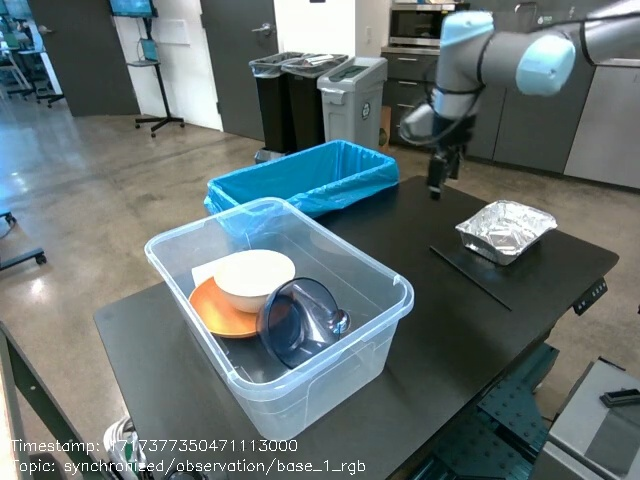

In [1076]:
idx = 12
test = data[idx]
print(test['action'])
# render_video(test['start_frame'], test['end_frame'], 10 ,0)
render_video(755, 800, 10 ,0)

Pick up Glass Bowl


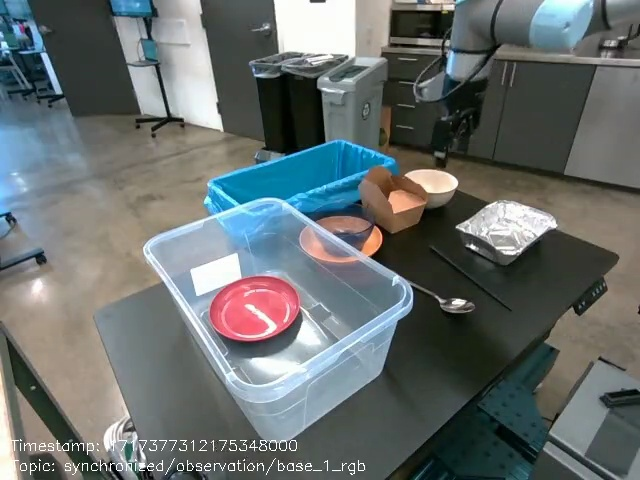

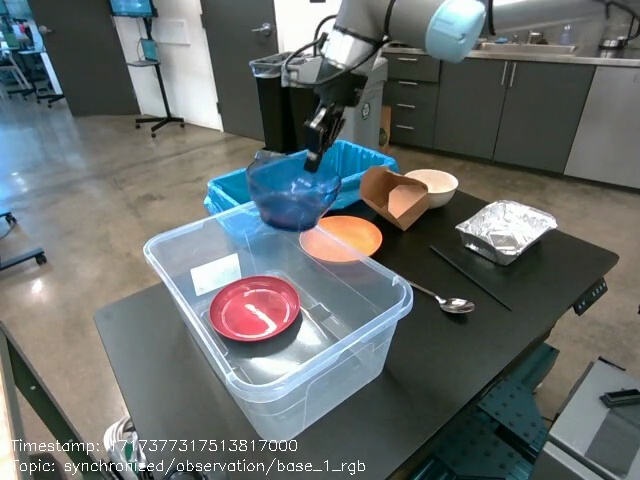

KeyboardInterrupt: 

In [231]:
for idx, action_dict in enumerate(data): 
    print(action_dict['action'])
    end_image_index = action_dict['end_image'] - 1
    render_video(action_dict['start_frame'], action_dict['end_frame'], 10, 0)
    render_video(action_dict['start_frame'], action_dict['end_frame'], 10 )

In [1201]:
LABEL_PICKUP_ACTION = """
### Analyze the Robot's Pickup Action

**Action Description:**
The robot attempts to pick up the object `{object}`. Your task is to identify the precise images where the pickup action starts and ends.

**Objective:**
Meticulously determine the exact image numbers marking the start and conclusion of the pickup action involving `{object}`.

**Instructions:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot gripper should not be grasping or holding any objects, including `{object}`
   - **Criterion 2:** The robot gripper should be about to pick up `{object}`, but has some space in between the gripper and the object.
   - **Criterion 3:** The gripper should be positioned away from any objects, and the following frames should capture the robot gripper moving towards the `{object}`, before it picks it up. 

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the image where `{object}` is securely held by the gripper and fully lifted off the table. If `{object}` is still touching the table, select a subsequent frame.
   - **Criterion 2:** Ensure that `{object}` has not yet started moving towards the destination (bin / container). It should have just been picked up, and not yet started its trajectory towards the destination.
   - **Criterion 3:** The `{object}` should not be over the container / bin yet.
   
**Focus Points:**
   - Concentrate solely on interactions involving `{object}`.
   - Ignore any images where the robot interacts with other objects not relevant to the specific pickup action of `{object}`.

**Expected Deliverables:**
   - Document the image numbers that correctly represent both the start and end of the pickup action.
   - Double-check the images against these criteria to ensure accuracy.

**Sample Response Format:**
```json
{{
  "start_image": [image number],
  "end_image": [image number]
}}
"""


LABEL_DEPOSIT_ACTION = """
### Analyze the Robot's Depositing Action

**Action Description:**
The robot is engaged in depositing the object `{object}` into its designated destination. Your task is to identify the precise images where the depositing action begins and ends.

**Objective:**
Accurately determine the exact image numbers marking the start and conclusion of the depositing action involving `{object}`.

**Instructions:**

**1. Start Image Criteria for Deposit:**
   - **Criterion 1:** Identify the image where the robot’s gripper is securely holding `{object}`, which should be elevated and not yet positioned over its final destination. If `{object}` is already positioned over the destination, select an earlier frame as the start.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Deposit:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Focus Points:**
   - Maintain an exclusive focus on interactions involving `{object}`.
   - Ignore images involving other objects unless they directly impact the depositing action.

**Expected Deliverables:**
   - Document the image numbers for both the start and end of the deposit action.
   - Ensure the images meet the detailed criteria listed above for accurate assessment.

**Sample Response Format:**
```json
{{
  "start_image": [image number],
  "end_image": [image number]
}}
"""

In [1797]:

# CHECK_PICKUP_START_IMAGE_TIMING = """
# ### Analyze the Robot's Pickup Action: {action}

# **Context:**
# You are assigned to analyze a sequence in which a robot attempts to pick up {object}. The aim is to verify this if the first image FULLY encapsulates the criteria.

# **Helpful information:**: 
# To check if an object is grasped, check if the robot grippers are holding anything. 
# If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
# The chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the chopstick.

# **1. Start Image Criteria for Pickup:**
#    - **Criterion 1:** The robot gripper should not be grasping or holding any objects, including `{object}`
#    - **Criterion 2:** The robot gripper should be about to pick up `{object}`, but has some space in between the gripper and the object.
#    - **Criterion 3:** The gripper should be positioned away from any objects, and the following frames should capture the robot gripper moving towards the `{object}`, before it picks it up. 

# **2. End Image Criteria for Pickup:**
#    - **Criterion 1:** Identify the image where `{object}` is securely held by the gripper and fully lifted off the table. If `{object}` is still touching the table, select a subsequent frame.
#    - **Criterion 2:** Ensure that `{object}` has not yet started moving towards the destination (bin / container). It should have just been picked up, and not yet started its trajectory towards the destination.
   
# **Instruction:**
# Evaluate if the first image strictly satisfies the criteria for the START image of this action {action}? 
# Focus on evaluating the first image only.

# **Import information that applies throughout the video:**
# If in the video, the robot lifts another object first that isn't {object}, return  "early".

# After reasoning about the answer, return a JSON indicating whether the perfect START image for this action is "perfect" (meaning the perfect image is the first image showed above), "early" (meaning the first image showed above is too early), or "late" (meaning the first image showed above is too late).

# Example:  
# [Reasoning]
# ```json
# {{
# "answer":"perfect"
# }}
# """

# CHECK_PICKUP_START_IMAGE_TIMING = """
# ### Analyze the Robot's Pickup Action: {action}

# **Context:**
# You are tasked to analyze a sequence where a robot attempts to pick up {object}. The primary goal is to verify if the first image completely encapsulates the criteria for a successful start of the pickup action.

# **Helpful Information:**
# - If an object is no longer visible on the table and is not in the robot's gripper, it implies it has been deposited at the destination.
# - The chopstick, if applicable, is often hard to see when grasped. Pay special attention if the object is a chopstick.

# **Initial Check:**
# - **Check 1:** Determine if the first object the robot interacts with is {object}. If not, respond with "wrong_object". This check precedes any other analysis.

# **Detailed Criteria for Pickup:**

# **1. Start Image Criteria for Pickup:**
#    - **Criterion 1:** The robot's gripper should not be grasping or holding any objects, including {object}.
#    - **Criterion 2:** The robot's gripper should be about to pick up {object}, with some space between the gripper and the object.
#    - **Criterion 3:** The gripper should be positioned away from any objects, with subsequent frames showing the gripper moving towards {object} before picking it up.

# **2. End Image Criteria for Pickup:**
#    - **Criterion 1:** Identify the frame where {object} is securely held by the gripper and fully lifted off the table. If {object} is still touching the table, choose a later frame.
#    - **Criterion 2:** Ensure that {object} has not started moving towards any destination like a bin or container. It should be just picked up, not yet moving towards the destination.

# **Instruction:**
# - First, evaluate if the robot initially interacts with {object}. If the first interaction is with a different object, return "wrong_object".
# - Next, evaluate if the first image strictly satisfies the criteria for the START image of this action {action}. Focus solely on the first image.

# **Expected Response:**
# - If the first object touched is not {object}, return "wrong_object".
# - Otherwise, after reasoning about the answer based on the start image criteria, return a JSON indicating whether the START image for this action is "perfect", "early", or "late".

# **Example Response:**
# ```json
# {{
#   "answer": "perfect"  // Options are "perfect", "early", "late", or "wrong_object"
# }}
# # """
CHECK_PICKUP_START_IMAGE_TIMING = """
### Analyze the Robot's Pickup Action: {action}

**Context:**
You are tasked to analyze a sequence where a robot attempts to pick up {object}. The primary goal is to verify if the first image completely encapsulates the criteria for a successful start of the pickup action.

**Helpful Information:**
- If an object is no longer visible on the table and is not in the robot's gripper, it implies it has been deposited at the destination.
- The chopstick, if applicable, is often hard to see when grasped. Pay special attention if the object is a chopstick.

**Initial Check:**
- **Check 1:** Determine if the first object the robot holds in its gripper is {object}. If the robot is seen holding an object other than {object} in three consecutive images, respond with "wrong_object". 
The reason for having 3 consecutive images is that it prevents false positives like knocking over another object. To be the wrong_object, a different object than {object} needs to be in the roobot gripper for 3 seperate images. This check precedes any other analysis.

**Detailed Criteria for Pickup:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot's gripper should not be holding any objects, including {object}.
   - **Criterion 2:** The robot's gripper should be positioned to soon pick up {object}, with visible space between the gripper and the object.
   - **Criterion 3:** The gripper should be positioned away from any objects, with subsequent frames showing the gripper moving towards {object} before picking it up.

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the frame where {object} is securely held by the gripper and fully lifted off the table. If {object} is still touching the table, choose a later frame.
   - **Criterion 2:** Ensure that {object} has not started moving towards any destination like a bin or container. It should be just picked up, not yet moving towards the destination.
   - **Criterion 3:** The {object} should be firmly in the grasp of the robot. It should be above the table, and not close yet to the bin/container. If so, the image is too late.

**Instruction:**
- First, evaluate if the robot initially holds {object} in its gripper. If the first object held is not {object} and this is shown in three consecutive images, return "wrong_object". It is important for it to be shown in three consecutive images to avoid false positives.
- Next, evaluate if the first image strictly satisfies the criteria for the START image of this action {action}. Focus solely on the first image.

**Expected Response:**
- If the first object held in the gripper is not {object}, return "wrong_object".
- Otherwise, after reasoning about the answer based on the start image criteria, return a JSON indicating whether the START image for this action is "perfect", "early", or "late".

**Example Response:**
[Reasoning]
```json
{{
  "answer": "perfect"  // Options are "perfect", "early", "late", or "wrong_object"
}}
"""

CHECK_PICKUP_END_IMAGE_TIMING = """
### Analyze the Robot's Pickup Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to pick up {object}. The aim is to verify this if the final image FULLY encapsulates the criteria.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are holding anything. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
The chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the chopstick.

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot gripper should not be grasping or holding any objects, including `{object}`
   - **Criterion 2:** The robot gripper should be about to pick up `{object}`, but has some space in between the gripper and the object.
   - **Criterion 3:** The gripper should be positioned away from any objects, and the following frames should capture the robot gripper moving towards the `{object}`, before it picks it up. 

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the image where `{object}` is securely held by the gripper and fully lifted off the table. If `{object}` is still touching the table, select a subsequent frame.
   - **Criterion 2:** Ensure that `{object}` has not yet started moving towards the destination (bin / container). It should have just been picked up, and not yet started its trajectory towards the destination.
   - **Criterion 3:** The {object} should be firmly in the grasp of the robot. It should be above the table, and not close yet to the bin / container. If so, the image is too late.

**Instruction:**
Evaluate if the last image strictly satisfies the criteria for the END image of this action {action}
Focus on evaluating the last image only.

After reasoning about the answer, return a JSON indicating whether the perfect END image for this action is "perfect" (meaning its the final image showed above), "early" (meaning the final image showed above is too early), or "late" (meaning the final image showed above is too late).

Example:  
[Reasoning]
```json 
{{
"answer":"perfect"    
}}
"""


CHECK_DEPOSIT_START_IMAGE_TIMING = """
### Analyze the Robot's Putting Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to deposit an {object} into a destination. The aim is to verify this if the first image FULLY encapsulates the criteria.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are closed and holding the object. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
The chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the chopstick.

**1. Start Image Criteria for Deposit:**
   - **Criterion 1:** Identify the image where the robot’s gripper has lifted the `{object}` above the table. There should be a signifcant visible gap between the table and the {object}.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Deposit:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Instruction:**
Evaluate if the first image strictly satisfies the criteria for the START image of this action {action}
Focus on evaluating the first image only.

After reasoning about the answer, return a JSON indicating whether the perfect START image for this action is "perfect" (meaning the perfect image is the first image showed above), "early" (meaning the first image showed above is too early), or "late" (meaning the first image showed above is too late).

Example:  
[Reasoning]
```json
{{
"answer":"perfect"
}}
"""


CHECK_DEPOSIT_END_IMAGE_TIMING = """
### Analyze the Robot's Putting Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to deposit an {object} into a destination. The aim is to verify this if the final image FULLY encapsulates the criteria.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are holding anything. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
If the action is to place the object in the bin, once deposited you are not able to see the object any more. 
The chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the chopstick.

**1. Start Image Criteria for Deposit:**
   - **Criterion 1:** Identify the image where the robot’s gripper is securely holding `{object}`, which should be elevated and not yet positioned over its final destination. If `{object}` is already positioned over the destination, select an earlier frame as the start.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Deposit:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Instruction:**
Evaluate if the last image strictly satisfies the criteria for the END image of this action {action}
Focus on evaluating the last image only.

After reasoning about the answer, return a JSON indicating whether the perfect END image for this action is "perfect" (meaning its the final image showed above), "early" (meaning the final image showed above is too early), or "late" (meaning the final image showed above is too late).
Think step by step through the criteria. 

Example:  
[Reasoning] 
```json
{{
"answer":"perfect"
}}
"""


In [1798]:
import asyncio
import copy

from video_labeling.utils import extract_frames_from_video
# from video_labeling.prompts.shared import SYSTEM_PROMPT

# from video_labeling.prompts.reflection_checks import (
#     VIDEO_DESCRIPTION,
#     CHECK_WRONG_ACTION,
#     CHECK_PICKUP_START_IMAGE_TIMING,
#     CHECK_PICKUP_END_IMAGE_TIMING,
#     CHECK_DEPOSIT_START_IMAGE_TIMING,
#     CHECK_DEPOSIT_END_IMAGE_TIMING,
# )

from video_labeling.utils import (
    vlm_request,
    extract_json_from_response,
    adjust_fps_to_frame_count,
)

def create_check_prompts(task_type, task_name, object_name):
    """Creating the prompt template to run the checks"""
    if task_type == "pick":
        start_prompt = CHECK_PICKUP_START_IMAGE_TIMING.format(
            action=task_name, object=object_name
        )
        end_prompt = CHECK_PICKUP_END_IMAGE_TIMING.format(
            action=task_name, object=object_name
        )
    elif task_type == "put":
        start_prompt = CHECK_DEPOSIT_START_IMAGE_TIMING.format(
            action=task_name, object=object_name
        )
        end_prompt = CHECK_DEPOSIT_END_IMAGE_TIMING.format(
            action=task_name, object=object_name
        )
    else:
        raise ValueError(f"Unsupported task type: {task_type}")
    return start_prompt, end_prompt

async def check_action_frame_number_labels(action, client, video_path, fps=5):
    """Check timing  """
    start_frame, end_frame = action["start_frame"], action["end_frame"]

    frames, _ = adjust_fps_to_frame_count(
        video_path, start_frame, end_frame, fps, 5, 20
    )

    start_prompt, end_prompt = create_check_prompts(
        action["action_type"], action["action"], action["object"]
    )
    start_response = await vlm_request(
        client, SYSTEM_PROMPT, start_prompt, frames, extract_json=False
    )
    end_response = await vlm_request(
        client, SYSTEM_PROMPT, end_prompt, frames, extract_json=False
    )

    action.update(
        {
            "start_answer": start_response,
            "end_answer": end_response,
            "start_check": extract_json_from_response(start_response)["answer"],
            "end_check": extract_json_from_response(end_response)["answer"],
        }
    )

    return action


async def check_episode_frame_number_labels(client, video_path, labeled_actions, fps=5):
    tasks_to_process = [check_action_frame_number_labels(copy.deepcopy(action), client, video_path, fps=fps) for action in labeled_actions]
    responses = await asyncio.gather(*tasks_to_process)
    return responses


In [1852]:
checks_feedback_test_2 = await check_episode_frame_number_labels(client, VIDEO_PATH, test_frame_labels, fps=5)


In [1854]:
checks_feedback_test_2[10]

{'action': 'Pick up Aluminum Container',
 'start_image': 1,
 'end_image': 8,
 'start_frame': 675.0,
 'end_frame': 810.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Aluminum Container',
 'start_answer': '[Reasoning]\n\n1. **Initial Check:**\n   - The robot\'s gripper is seen holding a metal spoon in the first three images. This is not the Aluminum Container.\n\nSince the robot is holding a metal spoon in the first three images, it does not meet the criteria for picking up the Aluminum Container.\n\n```json\n{\n  "answer": "wrong_object"\n}\n```',
 'end_answer': '[Reasoning]\n\n1. **Criterion 1:** The robot gripper should be holding the Aluminum Container and it should be fully lifted off the table.\n   - In the final image, the robot gripper is holding the Aluminum Container, and it is fully lifted off the table.\n\n2. **Criterion 2:** The Aluminum Container should not yet have started moving towards the destination.\n   - In the final image, the Aluminum Container is still in the g

In [1880]:
action_test = await check_action_frame_number_labels(action_test, client, VIDEO_PATH,fps=5)

In [1881]:
action_test

{'action': 'Pick up Aluminum Container',
 'start_image': 1,
 'end_image': 8,
 'start_frame': 735.0,
 'end_frame': 810.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Aluminum Container',
 'start_answer': '[Reasoning]\n\n1. **Initial Check:**\n   - The robot\'s gripper is not holding any objects in the first image.\n   - The robot\'s gripper is positioned near the Aluminum Container, indicating it is about to pick it up.\n\n2. **Detailed Criteria for Pickup:**\n\n   **Start Image Criteria for Pickup:**\n   - **Criterion 1:** The robot\'s gripper is not holding any objects, including the Aluminum Container. (Satisfied)\n   - **Criterion 2:** The robot\'s gripper is positioned to soon pick up the Aluminum Container, with visible space between the gripper and the object. (Satisfied)\n   - **Criterion 3:** The gripper is positioned away from any objects, with subsequent frames showing the gripper moving towards the Aluminum Container before picking it up. (Satisfied)\n\nBased on the analy

In [1873]:
action_test

{'action': 'Pick up Aluminum Container',
 'start_image': 1,
 'end_image': 8,
 'start_frame': 705.0,
 'end_frame': 810.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Aluminum Container',
 'start_answer': '[Reasoning]\n\n1. **Initial Check:**\n   - The first object the robot holds in its gripper is a metal spoon, not the Aluminum Container. This is evident in the first three consecutive images where the robot\'s gripper is holding the metal spoon.\n\nGiven that the robot is holding a metal spoon in the first three consecutive images, the response should be "wrong_object".\n\n```json\n{\n  "answer": "wrong_object"\n}\n```',
 'end_answer': '[Reasoning]\nIn the final image, the robot\'s gripper is holding the Aluminum Container, and it is fully lifted off the table. The container is not yet moving towards the destination, as the gripper is still positioned above the table and not close to the bin or container. This satisfies the criteria for the END image of the action "Pick up Aluminum 

In [1805]:
checks_feedback_test_2[2]

{'action': 'Pick up Cardboard Food Container',
 'start_image': 7,
 'end_image': 9,
 'start_frame': 195.0,
 'end_frame': 255.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Cardboard Food Container',
 'start_answer': '[Reasoning]\n\n1. **Initial Check:**\n   - The first object the robot holds in its gripper is the Cardboard Food Container. This is evident as the robot\'s gripper is seen holding the Cardboard Food Container in the sequence of images.\n\n2. **Start Image Criteria for Pickup:**\n   - **Criterion 1:** The robot\'s gripper is not holding any objects in the first image.\n   - **Criterion 2:** The robot\'s gripper is positioned to soon pick up the Cardboard Food Container, with visible space between the gripper and the object.\n   - **Criterion 3:** The gripper is positioned away from any objects, with subsequent frames showing the gripper moving towards the Cardboard Food Container before picking it up.\n\nBased on the analysis, the first image satisfies all the criteria fo

In [1879]:
action_test['start_frame']

735.0

Pick up Aluminum Container
perfect
perfect


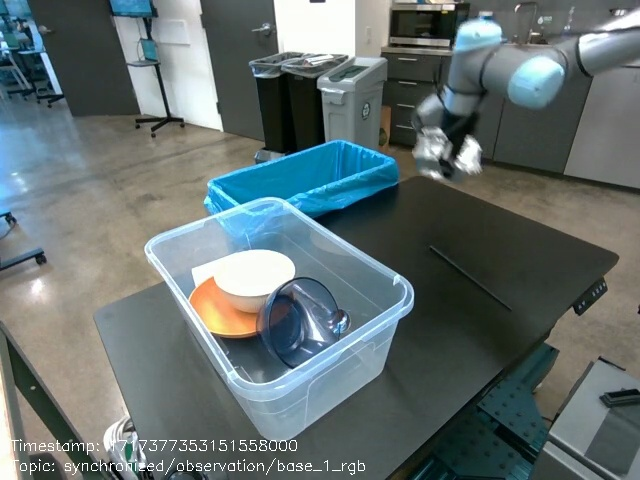

In [1869]:
idx = 10

test = checks_feedback_test_2[idx]
print(test['action'])
print(checks_feedback_test_2[idx]['start_check'])
print(checks_feedback_test_2[idx]['end_check'])
render_video(action_test['start_frame'], action_test['end_frame'], 10)

Pick up Aluminum Container


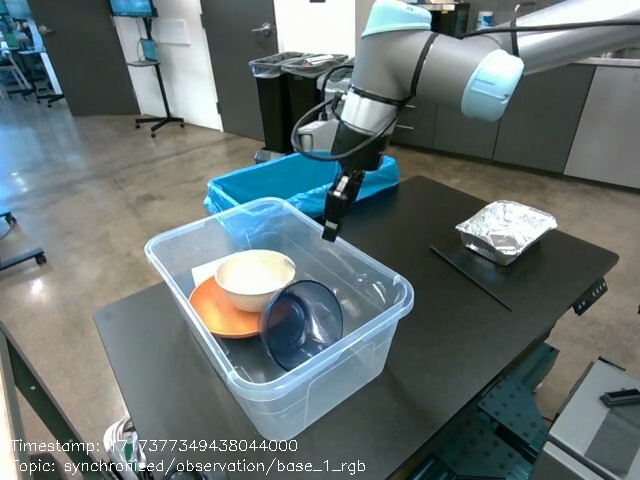

In [1884]:

print(action_test['action'])
render_video(action_test['start_frame'], action_test['end_frame'], 10, 0)


In [1328]:
checks_feedback[11]

{'action': 'Put Aluminum Container into Blue Trash Bin',
 'start_image': 3,
 'end_image': 6,
 'start_frame': 780.0,
 'end_frame': 840.0,
 'fps': 2,
 'action_type': 'put',
 'object': 'Aluminum Container',
 'start_answer': '[Reasoning]\n1. **Criterion 1:** In the first image, the robot’s gripper is not securely holding the Aluminum Container. The gripper is open and not in contact with the container.\n2. **Criterion 2:** The gripper is not actively moving towards the destination. It is stationary and positioned above the Aluminum Container.\n3. **Criterion 3:** The Aluminum Container is not lifted off the table. It is still resting on the table.\n\nBased on these criteria, the first image does not satisfy the conditions for the start image of the action "Put Aluminum Container into Blue Trash Bin." The gripper is not holding the container, and the container is not lifted off the table.\n\n```json\n{\n"answer":"early"\n}\n```',
 'end_answer': '[Reasoning]\n\n1. **Criterion 1:** The final 

wrong_object
perfect
Pick up Aluminum Container


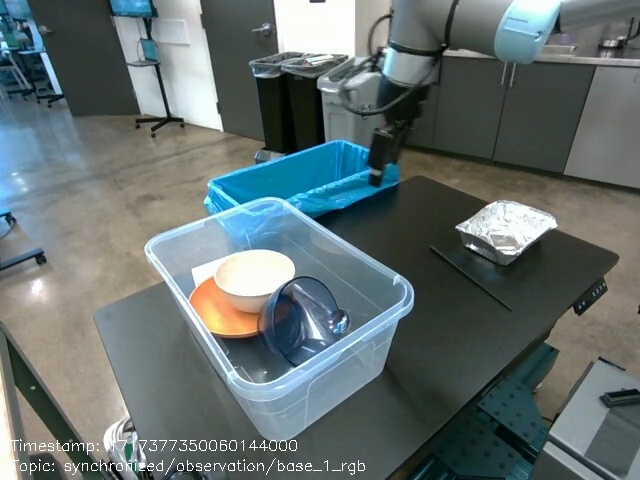

KeyboardInterrupt: 

In [1326]:
## idx = 
print(checks_feedback[idx]['start_check'])
print(checks_feedback[idx]['end_check'])

test = data[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10)


In [1129]:
CHECK_WRONG_ACTION = """
Follow these instructions in the correct order. 
First Step: 
Answer the question: in the images above, what object is the robot holding? 

Second Step: 
Select from one of the options below. 
What is the robot gripper holding (if anything).
The different options are: 
1) Robot gripper is empty (most likely)
2) Robot is holding {object} 
3) Robot is holdind a different object than {object}. 

If the answer is either option 1) or 2) , please return "perfect" in the answer.
If the answer is option 3), then please return "super early" in the answer.

First reason about your answer, then provide your answer in JSON.

Example:  
[Reasoning]
```json
{{
"answer":[answer]
}}
"""

In [1518]:
CHECK_WRONG_ACTION = """
In the beginning of the video (the first few images), what is happening? 
Does this match the description in the label: {action}? 
If it does, return "perfect". 
If the action at the beginning doesn't match with {action}, but it happens later on in the images, please return "later".
If {action} doesn't take place at all, please return "false".

Think step by step through this logic.
"""

CHECK_WRONG_ACTION = """
In the beginning of the video (the first few images), what is happening? 
Does this match the object: {object}? 
Respond with yes or no.

"""

CHECK_WRONG_ACTION = """
### Initial Interaction Analysis: {action}

**Context:**
You are tasked to analyze the first interaction in a sequence where a robot attempts to manipulate {object}. This analysis will determine if the robot's initial action involves correctly handling the intended object.

**Check 1: Initial Object Interaction**
- **Goal:** Confirm whether the first object the robot holds or grabs is {object}.
- **Responses:**
  - If the robot first holds or grabs {object}, return "perfect".
  - If the robot holds or grabs a different object, return "wrong_object".
  - If the robot does not hold or grab any object at all, return "perfect".

**Instruction:**
Examine the sequence and determine the nature of the first interaction:
- Focus on identifying whether the first object held or grabbed by the robot is indeed {object} or something else.

**Expected Response:**
- **"perfect"**: The first object the robot holds or grabs is {object}, or no interaction occurs.
- **"wrong_object"**: The robot begins by holding or grabbing an incorrect object.

**Example Response:**
[Reasoning]
```json
{{
  "answer": "perfect"  // Possible responses: "perfect" or "wrong_object"
}}
"""

CHECK_WRONG_ACTION = """
Explain the video step by step. 
In each image, explain if the robot gripper is empty / holding an object (and if so what object). 
"""


## Adjusting start label

In [1901]:
def adjust_frame_indices(original_frame, direction, num_seconds=1):
    """adjusting the frame to be """
    # there's 30 fps in these videos
    adjustment = 30  * num_seconds
    if direction == "backward":
        return max(0, original_frame - adjustment)
    elif direction == "forward":
        return original_frame + adjustment
    else:
        return original_frame

def adjust_task_frame(action):
    """
    Adjust the frame indices for a list of tasks based on 'start_check' and 'end_check'.
    It sets modified start and end frames to provide a buffer around the adjusted frames.
    """
  

    action["need_modification"] = action["start_check"] != "perfect" or action["end_check"] != "perfect"
    action["modified_start_start_frame"] = action["start_frame"] 
    action["modified_end_end_frame"] = action["end_frame"] 


    if action["start_check"] != "perfect": # only options here are 'early' and 'late'
        backward_seconds = 2 if action["start_check"] == "late" else 1
        forward_seconds = 1 if action["start_check"] == "late" else 2

        action["modified_start_start_frame"] = adjust_frame_indices(
            action["start_frame"], "backward", backward_seconds)
        action["modified_start_end_frame"] = adjust_frame_indices(
            action["start_frame"], "forward", forward_seconds)

    if action["end_check"] != "perfect": # only options here are 'early' and 'late'
        backward_seconds = 2 if action["end_check"] == "late" else 1
        forward_seconds = 1 if action["end_check"] == "late" else 2

        action["modified_end_start_frame"] = adjust_frame_indices(
            action["end_frame"], "backward", backward_seconds)
        action["modified_end_end_frame"] = adjust_frame_indices(
            action["end_frame"], "forward", forward_seconds)

    return action


In [1970]:
CHECK_PICKUP_START_IMAGE_TIMING = """
### Analyze the Robot's Pickup Action: {action}

**Context:**
You are tasked to analyze a sequence where a robot attempts to pick up {object}. The primary goal is to verify if the first image completely encapsulates the criteria for a successful start of the pickup action.

**Helpful Information:**
- If an object is no longer visible on the table and is not in the robot's gripper, it implies it has been deposited at the destination.
- The chopstick, if applicable, is often hard to see when grasped. Pay special attention if the object is a chopstick.

**Initial Check:**
- **Check 1:** Determine if the first object the robot holds in its gripper is {object}. If the robot is seen holding an object other than {object} in three consecutive images, respond with "wrong_object". 
The reason for having 3 consecutive images is that it prevents false positives like knocking over another object. To be the wrong_object, a different object than {object} needs to be in the roobot gripper for 3 seperate images. This check precedes any other analysis.

**Detailed Criteria for Pickup:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot's gripper should not be holding any objects, including {object}.
   - **Criterion 2:** The robot's gripper should be positioned to soon pick up {object}, with visible space between the gripper and the object.
   - **Criterion 3:** The gripper should be positioned away from any objects, with subsequent frames showing the gripper moving towards {object} before picking it up.

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the frame where {object} is securely held by the gripper and fully lifted off the table. If {object} is still touching the table, choose a later frame.
   - **Criterion 2:** Ensure that {object} has not started moving towards any destination like a bin or container. It should be just picked up, not yet moving towards the destination.
   - **Criterion 3:** The {object} should be firmly in the grasp of the robot. It should be above the table, and not close yet to the bin/container. If so, the image is too late.

**Instruction:**
- First, evaluate if the robot initially holds {object} in its gripper. If the first object held is not {object} and this is shown in three consecutive images, return "wrong_object". It is important for it to be shown in three consecutive images to avoid false positives.
- Next, evaluate if the first image strictly satisfies the criteria for the START image of this action {action}. Focus solely on the first image.

**Expected Response:**
- If the first object held in the gripper is not {object}, return "wrong_object".
- Otherwise, after reasoning about the answer based on the start image criteria, return a JSON indicating whether the START image for this action is "perfect", "early", or "late".

**Example Response:**
[Reasoning]
```json
{{
  "answer": "perfect"  // Options are "perfect", "early", "late", or "wrong_object"
}}
"""

CHECK_PICKUP_START_IMAGE_TIMING = """
### Analyze the Robot's Pickup Action: {action}

**Context:**
You are tasked to analyze a sequence where a robot attempts to pick up {object}. The primary goal is to verify if the first image completely encapsulates the criteria for a successful start of the pickup action.

**Helpful Information:**
- If an object is no longer visible on the table and is not in the robot's gripper, it implies it has been deposited at the destination.
- The chopstick, if applicable, is often hard to see when grasped. Pay special attention if the object is a chopstick.

**Initial Check:**
- **Check 1:** Determine if the first object the robot holds in its gripper is {object}. If the robot is seen holding an object other than {object} in three consecutive images, respond with "wrong_object". 
The reason for having 3 consecutive images is that it prevents false positives like knocking over another object. To be the wrong_object, a different object than {object} needs to be in the roobot gripper for 3 seperate images. This check precedes any other analysis.

**Detailed Criteria for Pickup:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot's gripper should not be holding any objects, including {object}.
   - **Criterion 2:** The robot's gripper should be positioned to soon pick up {object}, with visible space between the gripper and the object.
   - **Criterion 3:** The gripper should be positioned away from any objects, with subsequent frames showing the gripper moving towards {object} before picking it up.

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the frame where {object} is securely held by the gripper and fully lifted off the table. If {object} is still touching the table, choose a later frame.
   - **Criterion 2:** Ensure that {object} has not started moving towards any destination like a bin or container. It should be just picked up, not yet moving towards the destination.
   - **Criterion 3:** The {object} should be firmly in the grasp of the robot. It should be above the table, and not close yet to the bin/container. If so, the image is too late.

**Instruction:**
- First, evaluate if the robot initially holds {object} in its gripper. If the first object held is not {object} and this is shown in three consecutive images, return "wrong_object". It is important for it to be shown in three consecutive images to avoid false positives.
- Next, evaluate if the first image strictly satisfies the criteria for the START image of this action {action}. Focus solely on the first image.

**Expected Response:**
- If the first object held in the gripper is not {object}, return "wrong_object".
- Otherwise, after reasoning about the answer based on the start image criteria, return a JSON indicating whether the START image for this action is "perfect", "early", or "late".

**Example Response:**
[Reasoning]
```json
{{
  "answer": "perfect"  // Options are "perfect", "early", "late", or "wrong_object"
}}
"""


In [1984]:
import asyncio
import copy

from config import FPS_OPTIONS
from video_labeling.utils import extract_frames_from_video
from video_labeling.prompts.shared import SYSTEM_PROMPT
from video_labeling.prompts.label_frames import (
    REFINED_START_FRAME_PICK,
    REFINED_END_FRAME_PICK,
    REFINED_START_FRAME_DEPOSIT,
    REFINED_END_FRAME_DEPOSIT,
    LABEL_PICKUP_ACTION,
    LABEL_DEPOSIT_ACTION
)
# from video_labeling.prompts.reflection_checks import (
#     CHECK_PICKUP_START_IMAGE_TIMING,
#     CHECK_PICKUP_END_IMAGE_TIMING,
#     CHECK_DEPOSIT_START_IMAGE_TIMING,
#     CHECK_DEPOSIT_END_IMAGE_TIMING,
# )

from video_labeling.utils import (
    adjust_task_frames,
    vlm_request,
    calculate_expanded_range,
    # adjust_frame_indices, 
    adjust_fps_to_frame_count, 
    # adjust_task_frame
)

import pdb



async def adjust_frames_for_action(action_dict, client, video_path, fps):
    """Process a single robot task by calculating the range, getting frames, and analyzing the task."""
    action_type = action_dict["action_type"]
    action = action_dict["action"]
    object_name = action_dict["object"]
    start_check = action_dict["start_check"]
    counter= 0

    # only for pick start frame
    while start_check == "wrong_object" and counter <= 3: 
        # pdb.set_trace()
        action_dict["start_frame"] += 30

        frames, _ = adjust_fps_to_frame_count(
            video_path, action_dict["start_frame"], action_dict["end_frame"], fps, 5, 20
        )

        start_image_number = await vlm_request(
            client, SYSTEM_PROMPT, REFINED_START_FRAME_PICK, frames, extract_json=True
        )

        action_dict["start_frame"] += (start_image_number['answer'] - 1) * 30 / fps

        frames, _ = adjust_fps_to_frame_count(
            video_path, action_dict["start_frame"], action_dict["end_frame"], fps, 5, 20
        )

        start_check_json = await vlm_request(
                client,
                SYSTEM_PROMPT,
                CHECK_PICKUP_START_IMAGE_TIMING,
                frames,
                temperature=0,
                extract_json=True,
            )

        start_check = start_check_json['answer']
        action_dict["start_check"] = start_check

        counter += 1
        print(f"the action is: {action_dict['action']} and the check is: {start_check} after round {counter} and start frame is {action_dict['start_frame']}")
    
    action_dict = adjust_task_frame(action_dict)

    if not action_dict["need_modification"]:
        return action_dict

    counter = 0 # reset it
    while action_dict["need_modification"] and counter <3:
        print(f"action failing here is {action_dict['action']}. Start check is {action_dict['start_check']} and end check is {action_dict['end_check']}")

        if action_type == "pick":
            prompts = define_pick_prompts(action, object_name)
        elif action_type == "put":
            prompts = define_put_prompts(action, object_name)
        else:
            raise ValueError(f"Unsupported task type: {action_type}")

        if action_dict["start_check"] != "perfect":
            frames = extract_frames_from_video(
                video_path, start_frame=action_dict["modified_start_start_frame"], end_frame=action_dict["modified_start_end_frame"], fps=fps
            )
            start_frame = await vlm_request(
                client,
                SYSTEM_PROMPT,
                prompts["start_label_prompt"],
                frames,
                temperature=0.2,
                extract_json=True,
            )

            if start_frame is None: 
                continue
            start_image_number = start_frame.get("answer")
            if start_image_number is None: 
                continue
            
            action_dict["modified_start_start_frame"] += (start_image_number - 1) * 30 / fps
            frames = extract_frames_from_video(
                video_path, start_frame=action_dict["modified_start_start_frame"], end_frame=action_dict["modified_start_end_frame"], fps=fps
            )

            if len(frames)==0: 
                continue

            
            check_response = await vlm_request(
                client,
                SYSTEM_PROMPT,
                prompts["start_check_prompt"],
                frames,
                temperature=0.2,
                extract_json=True,
            )


            action_dict["start_check"] = check_response["answer"]
            if action_dict["start_check"] == "perfect": 
                print('\n\n')
                print(f"start check_response for {action_dict['action']} is {action_dict['start_check']}")
                print(f"modified_start_frame for {action_dict['action']} is: {action_dict['modified_start_start_frame']} and modified_end_frame is {action_dict['modified_start_end_frame']}")
                print('\n\n')
                action_dict["start_frame"] = action_dict["modified_start_start_frame"]
            else: 
                print('\n\n')
                print(f"start check_response for {action_dict['action']} is {action_dict['start_check']}")
                print(f"modified_start_frame for {action_dict['action']} is: {action_dict['modified_start_start_frame']} and modified_end_frame is {action_dict['modified_start_end_frame']}")
                print('\n\n')

        if action_dict["end_check"] != "perfect":

            frames = extract_frames_from_video(
                video_path, start_frame=action_dict["modified_end_start_frame"], end_frame=action_dict["modified_end_end_frame"], fps=fps
            )
            end_frame = await vlm_request(
                client,
                SYSTEM_PROMPT,
                prompts["end_label_prompt"],
                frames,
                temperature=0.2,
                extract_json=True,
            )

            if end_frame is None: 
                continue
            end_image_number = end_frame.get("answer")
            if end_image_number is None: 
                continue

            

            action_dict["modified_end_end_frame"] = action_dict["modified_end_start_frame"]+ end_image_number * 30 / fps
            frames = extract_frames_from_video(
                video_path, start_frame=action_dict["modified_end_start_frame"], end_frame=action_dict["modified_end_end_frame"], fps=fps
            )

            if len(frames)==0: 
                continue

            check_response = await vlm_request(
                client,
                SYSTEM_PROMPT,
                prompts["end_check_prompt"],
                frames,
                temperature=0.2,
                extract_json=True,
            )

            action_dict["end_check"] = check_response["answer"]
            if action_dict["end_check"] == "perfect": 
                print('\n\n')
                print(f"end check_response for {action_dict['action']} is {action_dict['end_check']}")
                print(f"modified_start_frame for {action_dict['action']} is: {action_dict['modified_end_start_frame']} and modified_end_frame is {action_dict['modified_end_end_frame']}")
                print('\n\n')
                action_dict["end_frame"] = action_dict["modified_end_end_frame"]
            else: 
                print('\n\n')
                print(f"end check_response for {action_dict['action']} is {action_dict['end_check']}")
                print(f"modified_start_frame for {action_dict['action']} is: {action_dict['modified_end_start_frame']} and modified_end_frame is {action_dict['modified_end_end_frame']}")
                print('\n\n')


        
        # Re-evaluate need for modification
        action_dict["need_modification"] = (
            action_dict["start_check"] != "perfect" or action_dict["end_check"] != "perfect"
        )

        print(f"reneed to modify is: {action_dict['need_modification']}")

        counter += 1

        if counter >= 3:
            action_dict["start_frame"] = action_dict["modified_start_start_frame"]
            action_dict["end_frame"] = action_dict["modified_end_end_frame"]

    return action_dict

def define_pick_prompts(action, object_name):
    return {
        "start_label_prompt": REFINED_START_FRAME_PICK.format(action=action, object=object_name),
        "end_label_prompt": REFINED_END_FRAME_PICK.format(action=action, object=object_name),
        "start_check_prompt": CHECK_PICKUP_START_IMAGE_TIMING.format(action=action, object=object_name),
        "end_check_prompt": CHECK_PICKUP_END_IMAGE_TIMING.format(action=action, object=object_name)
    }

def define_put_prompts(action, object_name):
    return {
        "start_label_prompt": REFINED_START_FRAME_DEPOSIT.format(action=action, object=object_name),
        "end_label_prompt": REFINED_END_FRAME_DEPOSIT.format(action=action, object=object_name),
        "start_check_prompt": CHECK_DEPOSIT_START_IMAGE_TIMING.format(action=action, object=object_name),
        "end_check_prompt": CHECK_DEPOSIT_END_IMAGE_TIMING.format(action=action, object=object_name),
    }


In [1978]:
async def adjusting_frames_in_episode(client, video_path, labeled_results, fps=5):
    tasks_to_process = [adjust_frames_for_action(copy.deepcopy(action), client, video_path, fps) for action in labeled_results]
    responses = await asyncio.gather(*tasks_to_process)
    filtered_responses = [response for response in responses if response is not None]

    return filtered_responses


In [1979]:
file_path = '/Users/niccolofusai/Documents/pi/checks_feedback_checkpoint.json'

# Open the file and load the data
with open(file_path, 'r') as file:
    checks_feedback = json.load(file)


wrong_object
perfect
Pick up Aluminum Container


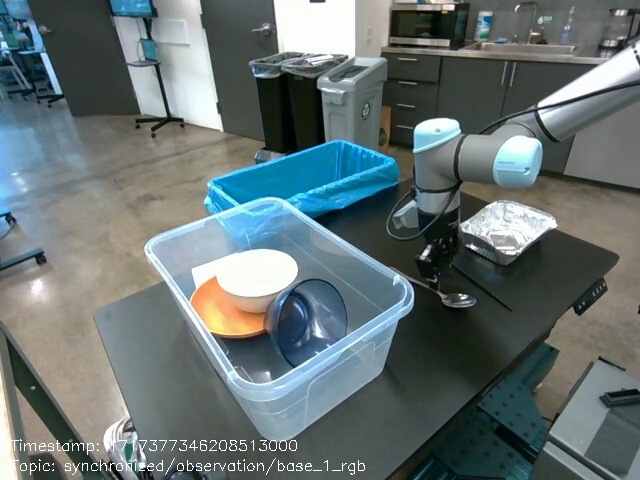

In [1980]:
idx = 10
print(checks_feedback[idx]['start_check'])
print(checks_feedback[idx]['end_check'])

test = data[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10,0)


In [1981]:
print(f"Step 5: Iteratively refining labels until all checks pass...")
final_results = await adjusting_frames_in_episode(client, VIDEO_PATH, checks_feedback, fps=5)


Step 5: Iteratively refining labels until all checks pass...
action failing here is Put Cardboard Food Container into Blue Trash Bin. Start check is early and end check is perfect
action failing here is Put Plastic Bowl into Clear Plastic Box. Start check is early and end check is perfect
action failing here is Put Black Chopstick into Clear Plastic Box. Start check is early and end check is early



start check_response for Put Plastic Bowl into Clear Plastic Box is perfect
modified_start_frame for Put Plastic Bowl into Clear Plastic Box is: 447.0 and modified_end_frame is 495.0



reneed to modify is: False



start check_response for Put Cardboard Food Container into Blue Trash Bin is perfect
modified_start_frame for Put Cardboard Food Container into Blue Trash Bin is: 258.0 and modified_end_frame is 270.0



reneed to modify is: False



start check_response for Put Black Chopstick into Clear Plastic Box is early
modified_start_frame for Put Black Chopstick into Clear Plastic Box i

In [1982]:
final_results[10]

{'action': 'Pick up Aluminum Container',
 'start_image': 1,
 'end_image': 8,
 'start_frame': 720.0,
 'end_frame': 810.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Aluminum Container',
 'start_answer': '[Reasoning]\n\n1. **Initial Check:**\n   - The robot\'s gripper is seen holding a metal spoon in the first image.\n   - The metal spoon is still in the gripper in the second and third images.\n\nSince the robot is holding a metal spoon in three consecutive images, it implies that the first object held by the robot is not the Aluminum Container.\n\n```json\n{\n  "answer": "wrong_object"\n}\n```',
 'end_answer': '[Reasoning]\n1. **Criterion 1:** The final image shows the robot gripper holding an object, which appears to be the Aluminum Container.\n2. **Criterion 2:** The Aluminum Container is securely held by the gripper and is fully lifted off the table.\n3. **Criterion 3:** The Aluminum Container has not yet started moving towards the destination. It is still above the table and not

perfect
perfect
Pick up Aluminum Container


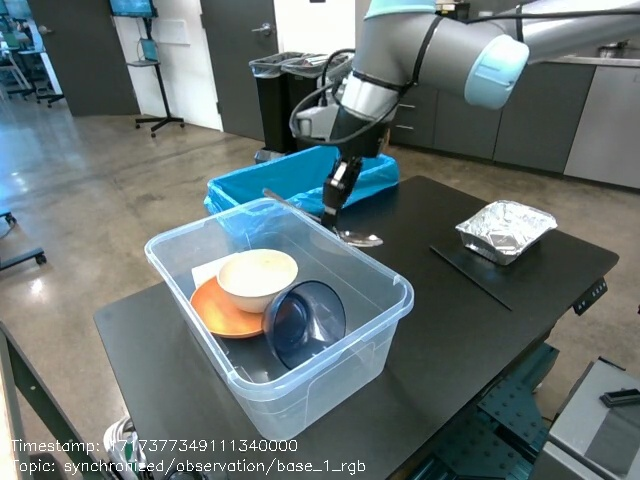

In [1983]:
idx = 10
print(final_results[idx]['start_check'])
print(final_results[idx]['end_check'])

test = final_results[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10,3)


In [1515]:
new_labeled_frames_test[0]

{'action': 'Pick up Glass Bowl',
 'start_image': 4,
 'end_image': 10,
 'start_frame': 15.0,
 'end_frame': 100.0,
 'fps': 3,
 'action_type': 'pick',
 'object': 'Glass Bowl'}

In [1522]:
async def determine_wrong_pickup_start_action(action, client, video_path, fps=5):
    """Determining if an action doesn't match the description label"""

    if action["action_type"]=="put": 
        return action

    print(f"original start frame for {action['action']} was {action['start_frame']}")
    moved_start_frame = action['start_frame'] + 15 # a second
    moved_end_frame = moved_start_frame + 30 # a second after that

    frames = extract_frames_from_video(video_path, moved_start_frame, moved_end_frame, fps=fps)

    prompt = CHECK_WRONG_ACTION.format(
        object=action["object"],
        action=action["action"],
    )

    wrong_object_response = await vlm_request(
        client, SYSTEM_PROMPT, prompt, frames, extract_json=False
    )

    # print(f"Response for {action['action']} is {wrong_object_response} \n\n")


    # check = wrong_object_response['answer']
    # print(f"{action['action']} is {check}")

    # if check != "perfect": 
    #     print(f"{action['action']} is APPARENTLY BAD")        
    #     action["start_frame"] += 45 # a second and a half

    #     frames = extract_frames_from_video(
    #             video_path, start_frame=action["start_frame"], end_frame=action["end_frame"], fps=fps
    #         )
        
        
    #     refined_frame_label_prompt = REFINED_START_FRAME_PICK.format(
    #             action=action["action"], object=action["object"]
    #         )
        
    #     start_frame_answer = await vlm_request(
    #             client,
    #             SYSTEM_PROMPT,
    #             refined_frame_label_prompt,
    #             frames,
    #             temperature=0,
    #             extract_json=True,
    #         )
        
    #     if start_frame_answer is None: 
    #         return action
    #     start_image_number = start_frame_answer.get("answer")
    #     if start_image_number is None: 
    #         return action
        
    #     action["start_frame"] += (start_image_number - 1) * 30 / fps

    # print(f"adjusted start frame for {action['action']} is {action['start_frame']}")

    return action


async def adjust_wrong_pickup_start_labels(client, video_path, labeled_timesteps, fps=5):
    """Getting rid of all erroneous actions in an episode"""

    tasks_to_process = [
        determine_wrong_pickup_start_action(copy.deepcopy(action), client, video_path, fps=fps)
        for action in labeled_timesteps
    ]
    responses = await asyncio.gather(*tasks_to_process)
    return responses


In [1520]:
print(f"Step 5: Removing erroneos actions...")
qa_answers = await adjust_wrong_pickup_start_labels(client, VIDEO_PATH, new_labeled_frames_test , fps=5)


Step 5: Removing erroneos actions...
original start frame for Pick up Glass Bowl was 15.0
original start frame for Pick up Cardboard Food Container was 185.0
original start frame for Pick up Orange Plate was 285.0
original start frame for Pick up Plastic Bowl was 375.0
original start frame for Pick up Metal Spoon was 570.0
original start frame for Pick up Aluminum Container was 715.0
original start frame for Pick up Black Chopstick was 855.0
Response for Pick up Cardboard Food Container is Sure, let's analyze the sequence of images step by step:

### Image 1:
- **Robot Gripper Status**: Empty
- **Action**: The robot arm is positioned above the black table, near the objects but not holding anything yet.

### Image 2:
- **Robot Gripper Status**: Holding an object
- **Object**: Cardboard Food Container
- **Action**: The robot gripper has picked up the cardboard food container from the black table.

### Image 3:
- **Robot Gripper Status**: Holding an object
- **Object**: Cardboard Food Con

TypeError: string indices must be integers

Response for Pick up Orange Plate is Here is a step-by-step explanation of the video sequence based on the provided images:

### Image 1:
- **Robot Gripper Status:** Empty
- **Action:** The robot arm is positioned above the black table, near the orange plate, but it has not yet picked up any object.

### Image 2:
- **Robot Gripper Status:** Holding the orange plate
- **Action:** The robot arm has moved slightly, and the gripper is now holding the orange plate, lifting it off the table.

### Image 3:
- **Robot Gripper Status:** Holding the orange plate
- **Action:** The robot arm is moving the orange plate towards the transparent plastic box on the black table.

### Image 4:
- **Robot Gripper Status:** Holding the orange plate
- **Action:** The robot arm is positioned above the transparent plastic box, preparing to place the orange plate inside.

### Image 5:
- **Robot Gripper Status:** Empty
- **Action:** The robot arm has released the orange plate into the transparent plastic box. The

In [ ]:
qa_answers[0]

Response for Pick up Plastic Bowl is No. 


Response for Pick up Glass Bowl is No. 


Response for Pick up Orange Plate is No. 


Response for Pick up Aluminum Container is No. 


Response for Pick up Black Chopstick is No. 


Response for Pick up Metal Spoon is No. 




In [ ]:
idx = 12
test = data[idx]
print(test['action'])
render_video(test['start_frame']+15, test['end_frame'], 10, 0)

Response for Pick up Cardboard Food Container is Yes. 


Response for Pick up Glass Bowl is Yes. 


Response for Pick up Orange Plate is Yes. 


Response for Pick up Aluminum Container is No. 


Response for Pick up Metal Spoon is No. 


Response for Pick up Black Chopstick is Yes. 




In [ ]:
# idx = 10
# test = data[idx]
# print(test['action'])
# moved_start_frame = test['start_frame'] + 30
# render_video(moved_start_frame, moved_start_frame+1, 5 ,10)

In [1098]:
letsee = await check_action_frame_number_labels(test, client, VIDEO_PATH)

In [1099]:
letsee

{'action': 'Pick up Black Chopstick',
 'start_image': 1,
 'end_image': 13,
 'start_frame': 830.0,
 'end_frame': 1035.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Black Chopstick',
 'start_answer': '[Reasoning]\nIn the first image, the robot arm is holding an object above the blue trash bin. The object appears to be an aluminum takeout container, which is consistent with the object destination rules. The robot arm is not holding the black chopstick in the first three images.\n\n```json\n{\n"answer":"super early"\n}\n```',
 'end_answer': '[Reasoning]\nIn the final image, the robot\'s gripper is holding the Black Chopstick, and there is visible space between the Black Chopstick and the table, indicating that the object has been lifted off the table. This satisfies the criteria for the END image of the action "Pick up Black Chopstick."\n\n```json\n{\n"answer":"perfect"\n}\n```',
 'start_check': 'super early',
 'end_check': 'perfect'}

In [1046]:
checks_feedback = await check_episode_frame_number_labels(client, VIDEO_PATH, data, fps=5)

In [1056]:
idx = 12

checks_feedback[idx]

{'action': 'Pick up Black Chopstick',
 'start_image': 1,
 'end_image': 13,
 'start_frame': 845.0,
 'end_frame': 1035.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Black Chopstick',
 'start_answer': '[Reasoning]\nIn the first three images, the robot\'s gripper is positioned above the black chopstick. The gripper appears to be in the process of picking up the black chopstick. There is no indication that the robot is holding any other object. Therefore, it is reasonable to conclude that the robot is holding the black chopstick.\n\n```json\n{\n"answer":"perfect"\n}\n```',
 'end_answer': '[Reasoning]\nIn the final image, the black chopstick is not visible on the table, indicating that it has been lifted. The robot\'s gripper appears to be holding the black chopstick, as there is no other object in its grasp. This satisfies the criteria for the END image of the action "Pick up Black Chopstick," where the chopstick must be lifted off the table and grasped by the robot.\n\n```json\n{\n"ans

Pick up Aluminum Container


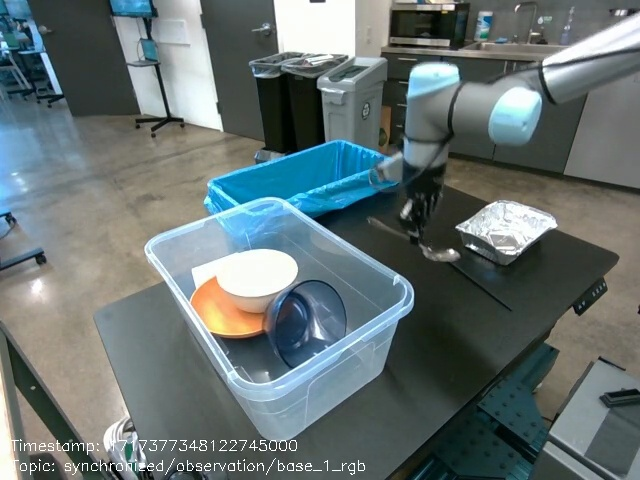

In [963]:
test = checks_feedback[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10, 0)

### Take action

In [364]:
REFINED_START_FRAME_PICK = """
### Analyze the Robot's Pickup Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to pick up {object}. The aim is to identify the correct START image that matches the criteria below.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are holding anything. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
The black chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the black chopstick.

**Criteria needeed for successful START image for PICK UP:**
- In the first image, the {object} needs to be on the table 
- In the first image, there is some space between the gripper and the {object}
- In the first image, the robot has not yet grasped the object

**Criteria needeed for successful END image for picking up:**
- In the final image, the {object} has been lifted off the table, enough to see space between the object and the table.
- In the final image, the {object} is grasped by the robot

**Instruction:**
From the images above, which image best describes the START image criteria above.

After reasoning about the answer, return a JSON for your answer.
Example:  
```json
{{
"answer":3
}}
"""


REFINED_END_FRAME_PICK = """
### Analyze the Robot's Pickup Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to pick up {object}. The aim is to identify the correct END image that matches the criteria below.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are holding anything. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
The black chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the black chopstick.

**Criteria needeed for successful START image for PICK UP:**
- In the first image, the {object} needs to be on the table 
- In the first image, there is some space between the gripper and the {object}
- In the first image, the robot has not yet grasped the object

**Criteria needeed for successful END image for picking up:**
- In the final image, the {object} has been lifted off the table, enough to see space between the object and the table.
- In the final image, the {object} is grasped by the robot

**Instruction:**
From the images above, which image best describes the END image criteria above.

After reasoning about the answer, return a JSON for your answer.
Example:  
```json
{{
"answer": 9
}}
"""


REFINED_START_FRAME_DEPOSIT = """
### Analyze the Robot's Putting Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to deposit an {object} into a destination. The aim is to identify the correct START image that matches the criteria below.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are holding anything. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
If the task is to place the object in the bin, once deposited you are not able to see the object any more. 
The black chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the black chopstick.

**Criteria needeed for successful START image for depositing an object:**
- In the first image, the {object} needs to be *starting* lifted above the table (to any degree).
- In the first image, the {object} needs to be not have been released yet.

**Criteria needeed for successful END image for depositing an object:**
- In the final image, the {object} is no longer airborn. 
- In the final image, the {object} was placed into one of the bin or plastic container

**Instruction:**
From the images above, which image best describes the START image criteria above.

After reasoning about the answer, return a JSON for your answer.
Example:  
```json
{{
"answer":3
}}
"""


REFINED_END_FRAME_DEPOSIT = """
### Analyze the Robot's Putting Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to deposit an {object} into a destination. The aim is to identify the correct START image that matches the criteria below.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are holding anything. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
If the task is to place the object in the bin, once deposited you are not able to see the object any more. 
The black chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the black chopstick.

**Criteria needeed for successful START image for depositing an object:**
- In the first image, the {object} needs to be *starting* lifted above the table (to any degree).
- In the first image, the {object} needs to be not have been released yet.

**Criteria needeed for successful END image for depositing an object:**
- In the final image, the {object} is no longer airborn. 
- In the final image, the {object} was placed into one of the bin or plastic container

**Instruction:**
From the images above, which image best describes the END image criteria above.

After reasoning about the answer, return a JSON for your answer.
Example:  
```json
{{
"answer": 9
}}

"""


In [792]:
async def adjust_frames_for_action(action_dict, client, video_path, fps):
    """Process a single robot task by calculating the range, getting frames, and analyzing the task."""
    action_type = action_dict["action_type"]
    object_name = action_dict["object"]
    start_frame, end_frame = (
        action_dict["modified_start_frame"],
        action_dict["modified_end_frame"],
    )
    need_modification = action_dict["need_modification"]

    if not need_modification:
        return action_dict

    while need_modification:
        print(action_dict['action'])
        frames = extract_frames_from_video(
            video_path, start_frame=start_frame, end_frame=end_frame, fps=fps
        )

        if action_type == "pick":
            start_prompt = REFINED_START_FRAME_PICK.format(
                action=action_dict, object=object_name
            )
            end_prompt = REFINED_END_FRAME_PICK.format(
                action=action_dict, object=object_name
            )
            start_check_prompt = CHECK_PICKUP_START_IMAGE_TIMING.format(
                action=action_dict, object=object_name
            )
            end_check_prompt = CHECK_PICKUP_END_IMAGE_TIMING.format(
                action=action_dict, object=object_name
            )
        elif action_type == "put":
            start_prompt = REFINED_START_FRAME_DEPOSIT.format(
                action=action_dict, object=object_name
            )
            end_prompt = REFINED_END_FRAME_DEPOSIT.format(
                action=action_dict, object=object_name
            )
            start_check_prompt = CHECK_DEPOSIT_START_IMAGE_TIMING.format(
                action=action_dict, object=object_name
            )
            end_check_prompt = CHECK_DEPOSIT_END_IMAGE_TIMING.format(
                action=action_dict, object=object_name
            )
        else:
            raise ValueError(f"Unsupported task type: {action_type}")

        if action_dict["start_check"] != "perfect":
            start_frame = await vlm_request(
                client,
                SYSTEM_PROMPT,
                start_prompt,
                frames,
                temperature=0,
                extract_json=True,
            )
            action_dict["modified_start_frame"] = start_frame.get("answer", "perfect")
            check_response = await vlm_request(
                client,
                SYSTEM_PROMPT,
                start_check_prompt,
                frames,
                temperature=0,
                extract_json=True,
            )
            action_dict["start_check"] = check_response["answer"]

        if action_dict["end_check"] != "perfect":
            end_frame = await vlm_request(
                client,
                SYSTEM_PROMPT,
                end_prompt,
                frames,
                temperature=0,
                extract_json=True,
            )
            action_dict["modified_end_frame"] = end_frame.get("answer", "perfect")
            check_response = await vlm_request(
                client,
                SYSTEM_PROMPT,
                end_check_prompt,
                frames,
                temperature=0,
                extract_json=True,
            )
            action_dict["end_check"] = check_response["answer"]

        # Re-evaluate need for modification
        action_dict["need_modification"] = (
            action_dict["start_check"] != "perfect" or action_dict["end_check"] != "perfect"
        )

        return action_dict


async def adjusting_frames_in_episode(client, video_path, labeled_results, fps=5):
    adjusted_tasks = adjust_task_frames(labeled_results)

    tasks_to_process = [adjust_frames_for_action(copy.deepcopy(action), client, video_path, fps) for action in adjusted_tasks]
    responses = await asyncio.gather(*tasks_to_process)
    return responses



In [793]:
final_results = await adjusting_frames_in_episode(client, VIDEO_PATH, checks_feedback, fps=5)


Put Cardboard Food Container into Blue Trash Bin
Put Aluminum Container into Blue Trash Bin
Put Black Chopstick into Clear Plastic Box


CancelledError: 

In [385]:
final_results[3]

{'action': 'Put Cardboard Food Container into Blue Trash Bin',
 'start_image': 5,
 'end_image': 8,
 'start_frame': 210.0,
 'end_frame': 270.0,
 'fps': 2,
 'action_type': 'put',
 'object': 'Cardboard Food Container',
 'start_answer': '[Reasoning]\n\nTo determine if the first image is the perfect START image for the action "Put Cardboard Food Container into Blue Trash Bin," we need to evaluate the following criteria:\n\n1. **Cardboard Food Container is starting to be lifted above the table:**\n   - In the first image, the Cardboard Food Container is still on the table and has not yet been lifted by the robot\'s gripper.\n\n2. **Cardboard Food Container has not been released yet:**\n   - Since the Cardboard Food Container is still on the table, it has not been released by the robot\'s gripper.\n\nBased on these criteria, the first image does not show the Cardboard Food Container starting to be lifted above the table. Therefore, the first image is too early to be considered the perfect STA

Put Aluminum Container into Blue Trash Bin


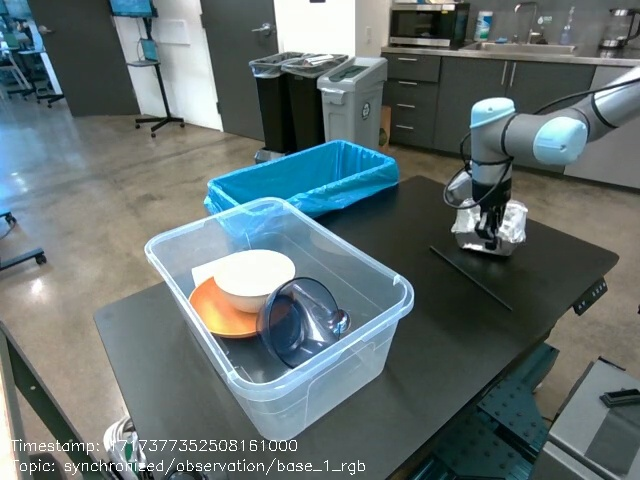

In [380]:
idx = 11
test = checks_feedback[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10 ,0)

Put Aluminum Container into Blue Trash Bin


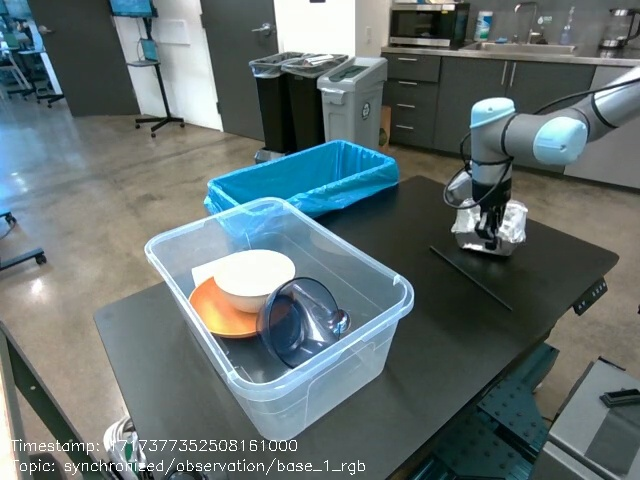

In [381]:
test = final_results[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10 ,0)

### Erroneous tweaks

In [298]:
test_data = data[10]
test_data

{'action': 'Pick up Aluminum Container',
 'start_image': 1,
 'end_image': 9,
 'start_frame': 690.0,
 'end_frame': 825.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Aluminum Container',
 'start_answer': '[Reasoning]\n\nTo determine if the first image is the perfect START image for the action "Pick up Aluminum Container," we need to evaluate it against the specified criteria:\n\n1. **Aluminum Container on the table**: The Aluminum Container is clearly visible on the table in the first image.\n2. **Space between the gripper and the Aluminum Container**: There is some space between the robot\'s gripper and the Aluminum Container in the first image.\n3. **Robot not grasping any object**: The robot\'s gripper is not holding any object in the first image.\n\nSince all the criteria for the START image are met in the first image, it is the perfect START image for the action "Pick up Aluminum Container."\n\n```json\n{\n"answer":"perfect"\n}\n```',
 'end_answer': '[Reasoning]\n\nTo determine 

In [355]:
VIDEO_DESCRIPTION = """
Is the {object} the only object that is picked or placed by the robot gripper in this video? 
"""

CHECK_WRONG_ACTION = """
### Analyze the Robot's Action: {action}

**Context:**
Your goal is to verify this action in the images is the same action as {action}.

**Instruction:**
Please answer the following question? 
- Are more than half of the images showing an action other than {action}? 

Reply with a simple yes or no and nothing else.
"""



CHECK_WRONG_ACTION = """
### Analyze the Robot's Action: {action}

**Context:**
You will be shown a series of images that reflect the robot taking action {action}, and a description of the video below.  

**Description of the video:**
{description}

**Instructions:**
From the description and the images, is the {object} the only obect being picked up or placed by the robot gripper? 
If it is, then return "correct". If there are several objects, return the start image of when the robot starts picking or placing the {object}. 
If the {object} is not picked or placed, and it is a different object, then return "wrong".  

**Example Answer:**
[Reasoning]
{{
"answer": "correct",
}}
"""

CHECK_WRONG_ACTION = """

Is the only object held by the robot gripper in these images the {object}? How about the metal spoon? 
"""

In [356]:
async def determine_erroneous_action(action, client, video_path, fps=5):
    """Determining if an action doesn't match the description label"""

    start_frame, end_frame = action["start_frame"], action["end_frame"]

    frames = extract_frames_from_video(video_path, start_frame, end_frame, fps=fps)
  
    prompt = CHECK_WRONG_ACTION.format(
        # action=action["action"],
        object=action["object"],
        # description=video_description,
    )
    wrong_object_response = await vlm_request(
        client, SYSTEM_PROMPT, prompt, frames, extract_json=False
    )

    return {
        "action": action["action"],
        "start_frame": start_frame,
        "end_frame": end_frame,
        "fps": fps,
        "action_type": action["action_type"],
        "object": action["object"],
        "wrong_object": wrong_object_response,
    }


async def remove_erroneous_actions(client, video_path, labeled_timesteps, fps=5):
    """Getting rid of all erroneous actions in an episode"""
    tasks_to_process = [
        determine_erroneous_action(copy.deepcopy(action), client, video_path, fps=fps) for action in labeled_timesteps
    ]
    responses = await asyncio.gather(*tasks_to_process)
    return [task for task in responses if task["wrong_object"] != "Yes"]


Pick up Metal Spoon


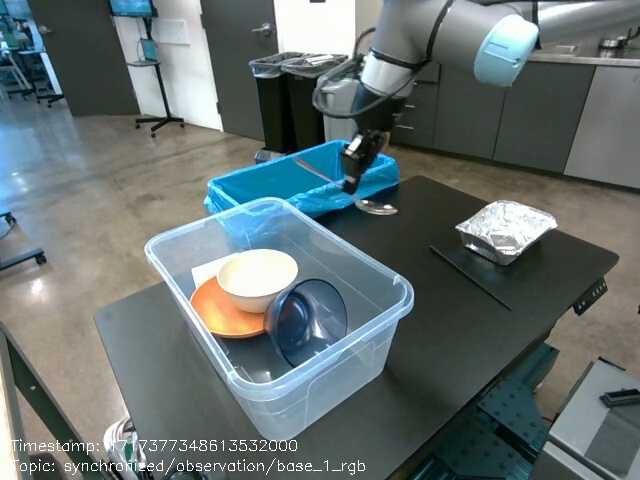

In [1080]:
idx = 8
test = data[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'],10 )

In [1081]:
pls = await determine_erroneous_action(test, client, VIDEO_PATH)

In [1082]:
pls

{'action': 'Pick up Metal Spoon',
 'start_frame': 530.0,
 'end_frame': 720.0,
 'fps': 5,
 'action_type': 'pick',
 'object': 'Metal Spoon',
 'wrong_object': 'Yes, the only object held by the robot gripper in these images is the metal spoon. The sequence of images shows the robot arm moving towards the metal spoon, grasping it, and lifting it. No other objects are seen being held by the robot gripper in these images.'}

### Step 5: For actions that weren't perfect, we can take action to correct them

In [69]:
final_results = await adjusting_frames_in_episode(checks_feedback)

Pick up Aluminum Container


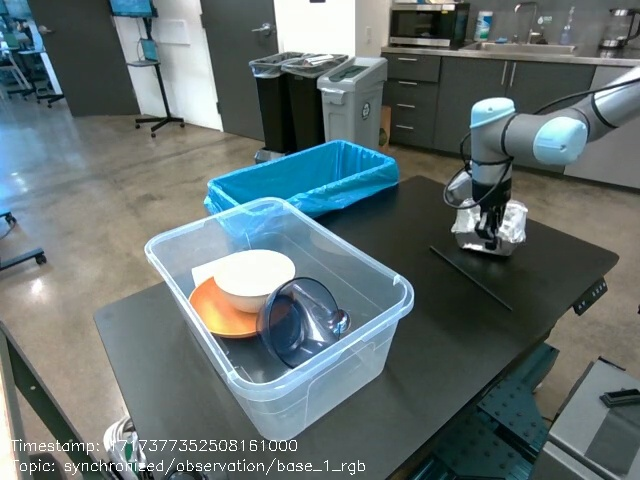

In [76]:
idx = 8
test = final_results[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], test['fps'] )

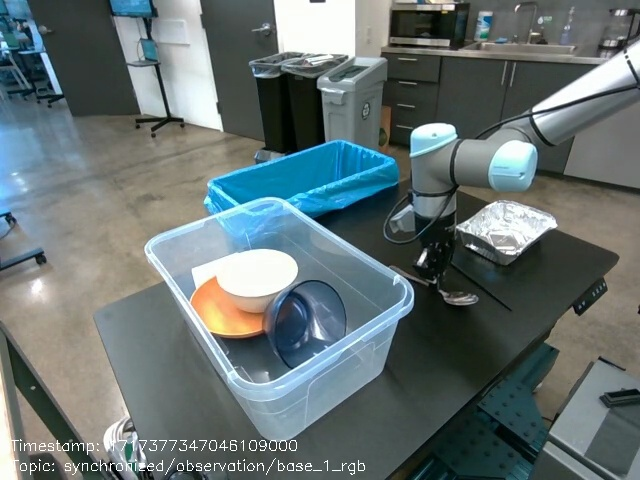

In [83]:
render_video(test['start_frame'], test['end_frame'], test['fps'], render_frame=0 )